# Case1: Contents of the HTTP request

In [36]:
var dbg = new Debugger("localhost", 25432);  // Using JDI

>> Debugger Info: Try to connect to localhost:25432
>> Debugger Info: Successflly connected to localhost:25432


In [37]:
dbg.run();
Point p = dbg.stopAt("tomcatdemo.App", 18).get(); // Stop at line 18

>> Debugger Info: Debugger started.


Visit http://localhost:8080/TomcatDemo-0.0.1/home once from Google Chrome

In [21]:
DebugResult dr = p.getResults().get("req");
var req = (ObjectInfo) dr.getLatestValue(); // Get the value of the variable req

In [22]:
req.invokeMethod(dbg.thread(), "getMethod");  // HTTP method

return of getMethod="GET"


In [23]:
req.invokeMethod(dbg.thread(), "getRequestURI"); // Request URI

return of getRequestURI="/TomcatDemo-0.0.1/home"


In [24]:
req.invokeMethod(dbg.thread(), "getHeader", "User-Agent"); // User-Agent header

return of getHeader="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.71 Safari/537.36"


# Case2: Identifying bottlenecks

In [1]:
var dbg = new Debugger("localhost", 39876, true); // Using ProbeJ

### Set up observation points at the boundary of each section

In [2]:
dbg.run();
String[] vars = {"noOfViews"};
List<Integer> lines = List.of(18, 20, 22, 24, 26);
var points = lines.stream()
                  .map(line -> dbg.watch("tomcatdemo.App", line, vars).get())
                  .collect(Collectors.toList());

Try to connect to localhost:39876
Succeccfully connected to localhost:39876
>> Debugger Info: Debugger started.


Visit http://localhost:8080/TomcatDemo-0.0.1/home once

### Display of observation results

In [3]:
var values =  new ArrayList<ValueInfo>();
points.forEach(p -> {
  var dr = p.getResults().get(vars[0]);
  values.add(dr.getLatestValue());
  println("value\t:\ttimestamp");
  dr.getValues().forEach(val -> {
    println(val.getValue()+"\t:\t"+val.getCreatedAt());
  }); 
})

value	:	timestamp
0	:	2021-10-07T01:59:04.270
value	:	timestamp
0	:	2021-10-07T01:59:04.583
value	:	timestamp
0	:	2021-10-07T01:59:04.692
value	:	timestamp
0	:	2021-10-07T01:59:09.703
value	:	timestamp
0	:	2021-10-07T01:59:09.905


### Visualization of processing time for each section

313.0
109.0
5011.0
202.0


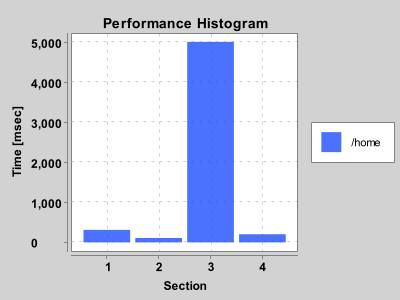

In [4]:
import java.time.temporal.ChronoUnit;

var x = new ArrayList<Double>();
var y = new ArrayList<Double>();

// Formatting data
for (int i = 0; i < values.size()-1; i++) {
  x.add((double) i+1);
  y.add((double) (ChronoUnit.MILLIS.between(values.get(i).getCreatedAt(), values.get(i+1).getCreatedAt())));
  println(y.get(i));
}

// Generating a diagram
CategoryChart chart = new CategoryChartBuilder().width(400).height(300).title("Performance Histogram")
                                                .xAxisTitle("Section").yAxisTitle("Time [msec]").build();
// Series
chart.addSeries("/home", x, y);
BitmapEncoder.getBufferedImage(chart);

### Survey results
- The bottleneck is **Section 3** 

In [35]:
dbg.exit();

EvalException: connection is closed

## Visualization by Grafana

In [39]:
var esExporter = new ElasticsearchExporter("http://localhost", 9200, "sample", "09:00");

In [40]:
for (ValueInfo value: values) {
  esExporter.update(value);  
};

In [41]:
esExporter.postJson();

In [18]:
esExporter.stop();

In [16]:
import java.time.LocalDateTime;
var vi = ValueInfoFactory.create("sample", 0, null, "1", LocalDateTime.now());
esExporter.update(vi);

0

In [38]:
var values = p.getResults().entrySet().stream().map(e->e.getValue().getLatestValue()).collect(Collectors.toList());